<h1>Evaluación de Support Vector Machine en reconocimiento de letras manuscritas usando el conjunto de datos EMNIST Letters - Aprendizaje Automático 1-2024</h1>

* <h5>Nombre: John Serrano Carrasco</h3>
* <h5>Profesora: Violeta Chang Camacho</h3>
* <h5>Ayudante: Bryan Salas Valenzuela</h3>

<h3>Breve Contexto</h3>
El objetivo de esta tarea es evaluar el desempeño de SVM en reconocimiento de letras manuscritas. Así, en esta tarea el foco estará en la clasificación de letras manuscritas usando el conjunto de datos EMNIST Letters. Para ello, se realizan tres experimetos, donde en cada uno se deberá entrenar una SVM usando un kernel RBF con parámetros por defecto:

1) Evaluar una SVM donde los vectores son directamente las imágenes convertidas a vectores

2) Lo mismo que el caso anterior, pero aplicando PCA para reducir las dimensiones a 128

3) Evaluar una SVM donde los vectores son extraídos de una red convolucional simple entrenada en EMNIST

Para los datos de entrenamiento, se utilizarán 1000 muestras de cada clase, seleccionadas aleatoriamente. Para los datos de prueba, se usarán 100 muestras aleatorias de cada clase.


<h3>Importaciones de Librerias</h3>
Se importan todas las librerias necesarias para ejecutar los códigos a continuación.

In [1]:
# Se importa todo lo que se utilizará a lo largo del jupyter notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

<h3> Lectura del Dataset "EMNIST Letters" </h3>
Para leer el Dataset que vine en un archivo .mat, se puede utilizar Scipy.

In [2]:
# Se carga y lee el archivo .mat utilizando scipy
file_path = 'emnist-letters.mat'
data = loadmat(file_path)

<h3>Obtención de datos de entrenamiento (train) y prueba (test)</h3>

El dataset se divide en conjuntos de entrenamiento y prueba. Cada conjunto incluye imágenes y etiquetas asociadas, donde las etiquetas indican la letra correspondiente de la imagen. Existe un mapeo entre las etiquetas numéricas y las letras del alfabeto De esta forma, se pueden obtener los conjuntos de entrenamiento y prueba.

In [3]:
# Se acceden a los datos de entrenamiento y prueba
train_data = data['dataset']['train'][0, 0]
test_data = data['dataset']['test'][0, 0]

# Se extra una subdivisión de los datos entre imágenes y etiquetas
train_images = train_data['images']
train_labels = train_data['labels']
test_images = test_data['images']
test_labels = test_data['labels']

# Se extraen las matrices reales de los contenedores para obtener las imágenes y etiquetas
extracted_train_images = train_images[0,0]
extracted_train_labels = train_labels[0,0]
extracted_test_images = test_images[0,0]
extracted_test_labels = test_labels[0,0]

# Se verifican las dimensiones de las imágenes y las etiquetas de los conjuntos de entrenamiento y prueba
(extracted_train_images.shape, extracted_train_labels.shape), (extracted_test_images.shape, extracted_test_labels.shape)


(((124800, 784), (124800, 1)), ((20800, 784), (20800, 1)))

<h3>Visualización de algunas de las imágenes obtenidas</h3>
Utilizando numpy se pueden obtener imágenes aleatorias y con matplotlib se pueden mostrar. Las imágenes corresponden a las que se obtienen desde el dataset, cada una con su label (etiqueta) correspondiente. Cabe destacar de que las imágenes originalmente vienen invertidas, por lo que es necesario utilizar reshape.T para así mostrar las imágenes correctamente.

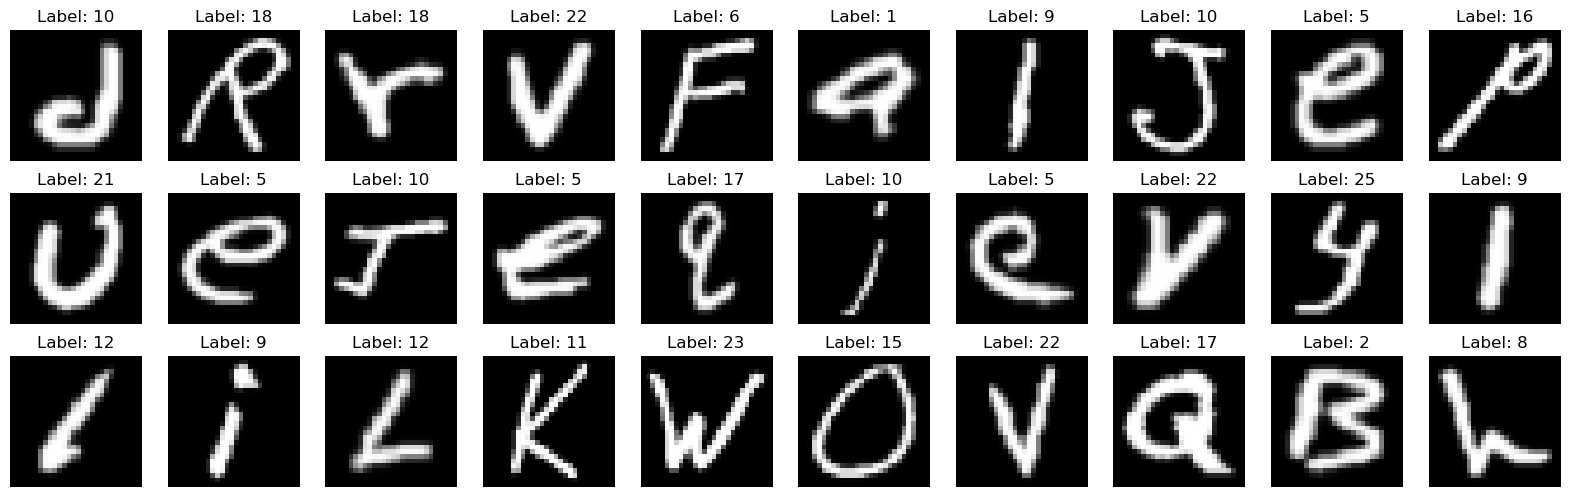

In [4]:
# Seleccionar 30 índices aleatorios
random_indices = np.random.choice(len(extracted_train_images), size=30, replace=False)

# Obtener las imágenes y etiquetas correspondientes
random_images = [extracted_train_images[i].reshape(28, 28).T for i in random_indices]
random_labels = [extracted_train_labels[i][0] for i in random_indices]

# Mostrar las 30 imágenes con sus etiquetas
fig, axes = plt.subplots(3, 10, figsize=(20, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(random_images[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Label: {random_labels[i]}')
plt.show()

<h3>Obtención de 1000 muestras de entrenamiento y 100 muestras de prueba para cada clase </h3> Se selecciona y separa de forma aleatoria 1000 muestras de entrenamiento y 100 muestras de prueba para cada una de las 26 clases, asegurando que no haya superposición entre los conjuntos. Esto se realiza mediante la indexación y selección de segmentos consecutivos de índices para cada clase, utilizando una semilla fija para garantizar la reproducibilidad.

In [5]:
# Se establece la semilla aleatoria en 64 para reproducibilidad
np.random.seed(64)

# Número de muestras por clase para entrenamiento y prueba
num_train_per_class = 1000
num_test_per_class = 100

# Se inicializan listas para almacenar los índices de entrenamiento y prueba
train_index = []
test_index = []

# Para todas las clases
for label in range(1, 27):
    # Se encuentran todos los índices donde la etiqueta es igual a la etiqueta actual
    index = np.where(extracted_train_labels == label)[0]
    
    # Se asegura que los índices están desordenados
    np.random.shuffle(index)
    
    # Se separan los índices para entrenamiento y prueba de forma secuencial para evitar mezclar
    train_i = index[:num_train_per_class]
    test_i = index[num_train_per_class:num_train_per_class + num_test_per_class]

    # Se agregan los índices a las listas correspondientes
    train_index.extend(train_i)
    test_index.extend(test_i)

# Se usan los índices para obtener las imágenes y etiquetas finales de entrenamiento y prueba
final_train_images = extracted_train_images[train_index, :]
final_train_labels = extracted_train_labels[train_index]
final_test_images = extracted_train_images[test_index, :]
final_test_labels = extracted_train_labels[test_index]

# Se comprueba que se obtuvo la cantidad de muestras solicitadas
print("Train images shape:", final_train_images.shape)
print("Train labels shape:", final_train_labels.shape)
print("Test images shape:", final_test_images.shape)
print("Test labels shape:", final_test_labels.shape)


Train images shape: (26000, 784)
Train labels shape: (26000, 1)
Test images shape: (2600, 784)
Test labels shape: (2600, 1)


<h3>Visualización de muestras obtenidas</h3>
Nuevamente utilizando matplotlib se pueden visualizar algunas de las muestras obtenidas de los conjuntos de entrenamiento y prueba.

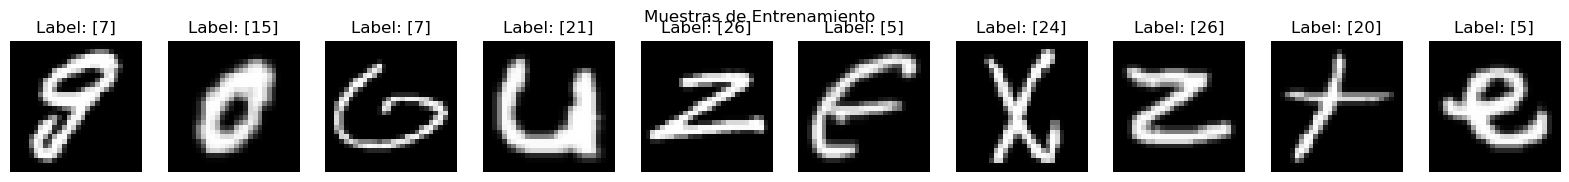

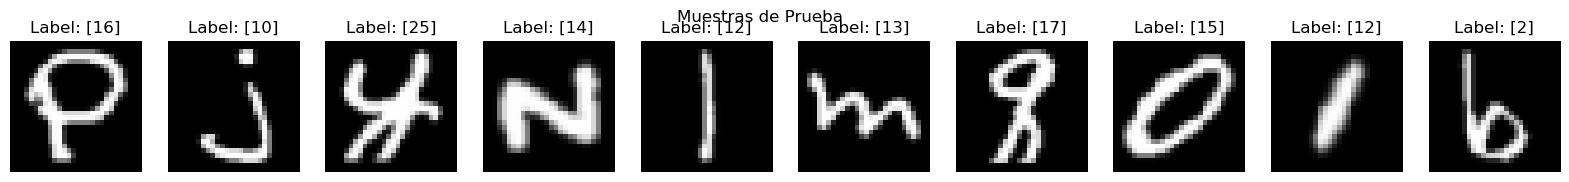

In [6]:
'''
Entrada: Un conjunto junto con sus etiquetas, el nombre de las muestras
Salida: No tiene como tal pero crea una grilla de subplots para mostrar las imágenes
Descripción: Función que muestra 10 samples de los conjuntos de entrenamiento y prueba.
'''
def plotSamples(images, labels, title, num_samples=10):
    # Se seleccionan aleatoriamente imágenes y etiquetas
    indices = np.random.choice(np.arange(len(images)), num_samples, replace=False)
    sample_images = np.array(images)[indices]
    sample_labels = np.array(labels)[indices]
    
    # Se crea una grilla de subplots
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))
    fig.suptitle(title)
    
    for i, ax in enumerate(axes):
        # Se muestran las imágenes correspondientes
        img = sample_images[i].reshape(28, 28).T # Se utiliza .T para mostrar las imágenes correctamente
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Label: {sample_labels[i]}')
        ax.axis('off')

# Se llama a la función para crear y mostrar los plots
plotSamples(final_train_images, final_train_labels, 'Muestras de Entrenamiento')
plotSamples(final_test_images, final_test_labels, 'Muestras de Prueba')



<h2>EXPERIMENTO 1: IMÁGENES CONVERTIDAS A VECTORES</h2>
El primer experimento corresponde en evaluar una SVM donde los vectores son directamente las  <b>imágenes convertidas a vectores</b>. Para ello, se declara un Pipeline usando svm con los parametros por defecto y el kernel RBF. Luego, se hace una verificación de que las labels están en un formato unidimensional, para así utilizarlas como parametros para la función <b>modelProcess()</b>, junto con los conjuntos de entrenamiento y prueba y el pipeline creado. Una vez que se llama a la función modelProcess(), se entrena el modelo, se evalua y se obtiene la accuracy total del modelo y el reporte de clasificación de cada clase, lo que indica metricas de desempeño interesantes como la precision y recall.

<h3>Entrenamiento, Predicción y Evaluación del modelo asociado al experimento 1</h3>
Se define la función modelProcess() y luego se utiliza para así entrenar, evaluar y verificar los resultados del modelo.

In [7]:
'''
Entradas: Un Pipeline y los conjuntos de entrenamiento y prueba con sus respectivos datos y etiquetas
Salidas: La accuracy total del modelo y los resultados tras la prueba del modelo
Descripción: Función que utiliza el Pipeline y los conjuntos para en primer lugar, entrenar el modelo,
luego evaluarlo. Tras esto, se obtiene la accuracy total de la SVM y también el reporte de clasificación
de cada clase, lo cual entrega distintas métricas.
'''
def modelProcess(pipeline, X_train, X_test, y_train, y_test):
    pipeline.fit(X_train, y_train) # Se entrena el modelo
    test_predictions = pipeline.predict(X_test)  # Se evalua el modelo

    # Se obtiene la Accuracy total de la SVM
    accuracy = accuracy_score(y_test, test_predictions)
    print("Accuracy total de la SVM: ", accuracy) 

    # Se obtiene el reporte de clasificación
    report = classification_report(y_test, test_predictions)
    print("Reporte de Clasificación (Métricas) de todas las clases:")
    print(report)
    return accuracy, test_predictions


In [8]:
# Configuración del pipeline
svm_pipeline = Pipeline([
    ('svm', SVC(kernel='rbf'))     # SVM con kernel RBF
])

# Se verifica que las etiquetas están en formato unidimensional
final_train_labels = np.array(final_train_labels).ravel()
final_test_labels = np.array(final_test_labels).ravel()

# Se llama a la función modelProcess() y se obtienen las predicciones del modelo junto con la accuracy total del modelo. Además, se imprime
# el reporte de clasificación.
accuracySVM1, test_predictionsE1 = modelProcess(svm_pipeline, final_train_images, final_test_images, final_train_labels, final_test_labels)

Accuracy total de la SVM:  0.8788461538461538
Reporte de Clasificación (Métricas) de todas las clases:
              precision    recall  f1-score   support

           1       0.77      0.88      0.82       100
           2       0.89      0.92      0.91       100
           3       0.91      0.95      0.93       100
           4       0.87      0.89      0.88       100
           5       0.96      0.92      0.94       100
           6       0.91      0.88      0.89       100
           7       0.74      0.68      0.71       100
           8       0.89      0.85      0.87       100
           9       0.71      0.76      0.73       100
          10       0.93      0.93      0.93       100
          11       0.92      0.89      0.90       100
          12       0.73      0.75      0.74       100
          13       0.93      0.95      0.94       100
          14       0.89      0.83      0.86       100
          15       0.91      0.98      0.94       100
          16       0.94      0.9

<h3>Matriz de Confusión y Accuracy por cada clase del Experimento 1</h3>
Se obtiene la Matriz de Confusión, cuya diagonal indica los resultados de predicción éxitosos y luego la Accuracy asociada a cada clase. Para ello, se crea y se utiliza la función <b>createConfusionMatrix()</b>

In [9]:
'''
Entrada: Las etiquetas del conjunto de test y los resultados tras evaluar el modelo SVM
Salida: Retorna un arreglo de Numpy con la accuracy por cada clase
Descripción: Función que utiliza las predicciones realizadas por el modelo para crear la Matriz de Confusión. La matriz se imprime y grafica,
para luego obtener la accuracy asociada a cada clase, la cual se muestra como un arreglo de Numpy.
'''
def createConfusionMatrix(y_test, y_pred):
    # Se crea la matriz de confusión usando confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Matriz de confusión:\n", cm)

    # Gráfico de la Matriz de Confusión
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 27), yticklabels=range(1, 27), vmin=0, vmax=np.max(cm))
    plt.xlabel('Predicciones')
    plt.ylabel('Etiquetas Verdaderas')
    plt.title('Matriz de Confusión')
    plt.show()

    # Cálculo y obtención de accuracy de cada clase
    class_accuracy = cm.diagonal() / cm.sum(axis=0)
    print("Accuracy por cada clase:\n", class_accuracy)
    return class_accuracy


Matriz de confusión:
 [[88  1  1  2  0  1  0  1  0  0  1  0  1  0  1  0  1  1  0  0  0  0  0  0
   0  1]
 [ 0 92  0  4  0  0  0  2  0  0  1  0  0  0  0  0  0  0  0  0  0  0  1  0
   0  0]
 [ 0  0 95  0  1  0  0  0  0  0  0  1  0  0  2  0  0  0  0  0  1  0  0  0
   0  0]
 [ 1  1  0 89  0  0  0  0  0  1  0  1  0  0  4  1  0  0  0  1  1  0  0  0
   0  0]
 [ 0  1  4  1 92  0  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0  0  0  0
   0  0]
 [ 2  0  0  0  0 88  0  0  2  0  0  1  0  0  0  1  0  2  0  3  0  0  0  0
   0  1]
 [ 6  2  0  1  0  1 68  0  1  1  0  0  0  0  0  1 15  0  4  0  0  0  0  0
   0  0]
 [ 1  0  0  0  0  0  0 85  0  0  0  1  2  5  0  1  0  3  0  1  0  0  0  1
   0  0]
 [ 0  0  0  1  0  0  0  0 76  1  0 20  0  0  0  0  0  0  0  1  0  0  0  0
   0  1]
 [ 0  0  0  0  0  0  1  0  1 93  0  2  0  0  0  0  0  0  1  1  0  1  0  0
   0  0]
 [ 0  1  0  0  0  2  1  1  0  0 89  0  0  2  0  0  0  2  0  0  0  1  0  1
   0  0]
 [ 0  1  0  0  0  0  0  0 21  1  0 75  0  0  0  0  0  1  0  0  1 

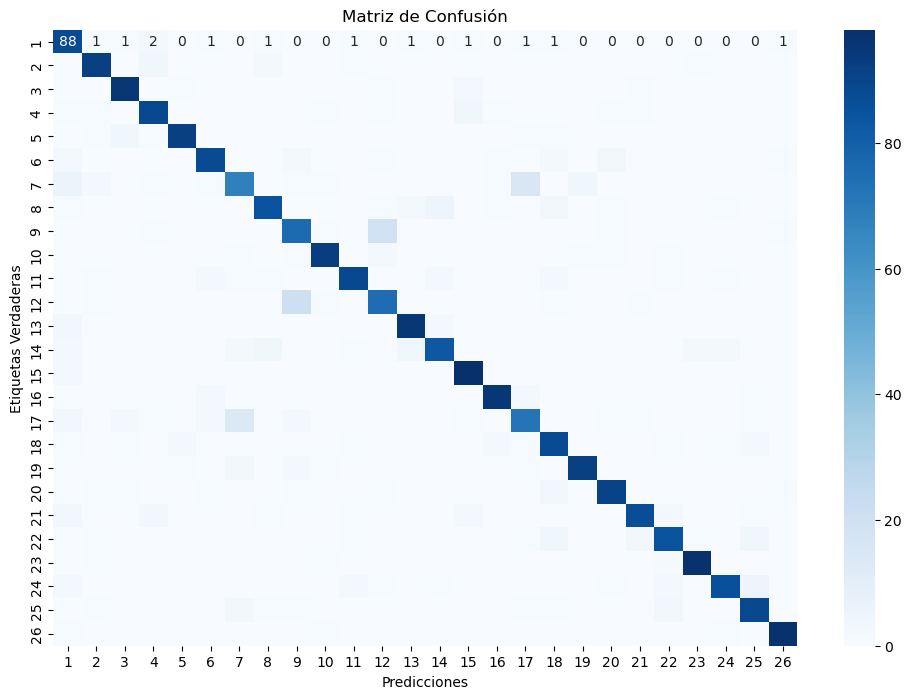

Accuracy por cada clase:
 [0.76521739 0.89320388 0.91346154 0.87254902 0.95833333 0.90721649
 0.73913043 0.89473684 0.71028037 0.93       0.91752577 0.72815534
 0.93137255 0.89247312 0.90740741 0.94059406 0.75789474 0.83018868
 0.94845361 0.91       0.92553191 0.88541667 0.96039604 0.93478261
 0.86407767 0.96039604]


In [10]:
# Creación de Matriz de Confusión y obtención de accuracy por cada clase
class_accuracyE1 = createConfusionMatrix(final_test_labels, test_predictionsE1)

<h3>Gráfico de Accuracy por cada clase del Experimento 1</h3>
Se crea y utiliza la función <b>createClassAccuracyPlot()</b> para crear y mostrar un gráfico que muestra la accuracy obtenida por cada clase.

In [11]:
'''
Entrada: Recibe un arreglo de Numpy que tiene la accuracy por cada clase
Salida: No tiene como tal, pero muestra el gráfico de barras de los valores de accuracy por cada clase
Descripción: Función que recibe el arreglo de Numpy que contiene la métrica de desempeño accuracy por cada clase y crea y muestra un gráfico de barras.
Para ello, inicialmente se crea un dataframe para registrar los valores de cada clase y poder graficar la información.
'''
def createClassAccuracyPlot(class_accuracy, experiment):
    # Se crea un dataframe, registrando los valores de accuracy por cada clase
    data = {
    'Clase': range(1, 27),
    'Accuracy': class_accuracy
    }
    df = pd.DataFrame(data)

    # Se realiza el grafico considerando la información guardada en el dataframe
    plt.figure(figsize=(14, 7))
    plt.bar(df['Clase'], df['Accuracy'], color='skyblue')
    plt.xlabel('Clase')
    plt.ylabel('Accuracy')
    plt.title('Accuracy por Clase del Experimento ' + str(experiment))
    plt.ylim(0, 1)  # Se establece el límite del eje y de 0 a 1 para claridad
    plt.xticks(df['Clase'])  # Se asegura que todas las etiquetas de clase estén en el eje x
    plt.show()

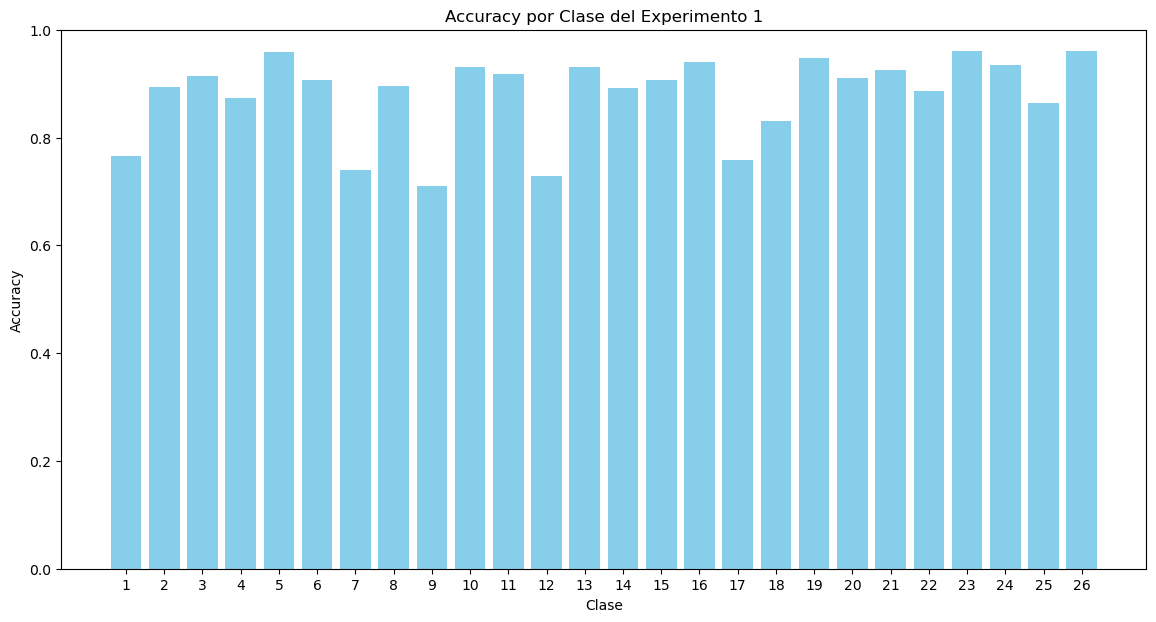

In [12]:
# Se crea y muestra el gráfico de barras asociado a cada clase
createClassAccuracyPlot(class_accuracyE1, 1)

<h3>Gráfico de Accuracy Total del modelo asociado al Experimento 1</h3>
Se crea y utiliza la función <b>createTotalAccuracyPlot()</b> para crear y mostrar un gráfico que muestra la accuracy total.

In [13]:
'''
Entrada: Accuracy total del modelo SVM asociado al experimento
Salida: No tiene como tal, pero muestra un gráfico de barras que representa el valor de la accuracy total
Descripción: Función que gráfica el valor de la accuracy total obtenido por el modelo SVM.
'''
def createTotalAccuracyPlot(accuracy, experiment):
    plt.figure(figsize=(6, 4))
    plt.bar(['Accuracy Total'], [accuracy], color='green')
    plt.ylim(0, 1)  # Se establece el límite del eje y de 0 a 1 para claridad
    plt.ylabel('Accuracy Total')
    plt.title('Accuracy Total del Modelo del Experimento ' + str(experiment))
    plt.show()
    

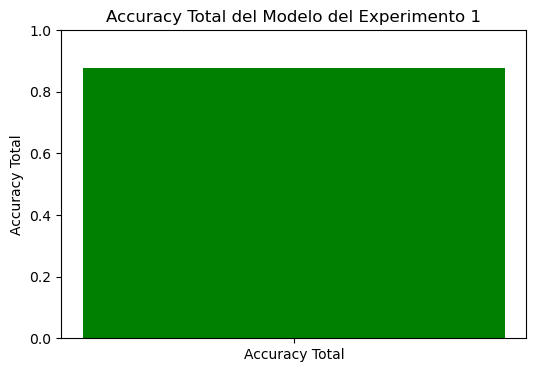

In [14]:
# Se muestra el gráfico de la Accuracy Total del modelo
createTotalAccuracyPlot(accuracySVM1, 1)

<h2>EXPERIMENTO 2: REDUCCIÓN DE DIMENSIONALIDAD CON PCA</h2>
El segundo experimento es prácticamente lo mismo que el caso anterior, pero aplicando <b>PCA para reducir las dimensiones a 128.</b> Por lo tanto, se modifica la configuración del Pipeline para utilizar PCA de Sklearn. Dado que el proceso del experimento 2 es muy similar al experimento 1, se vuelven a utilizar las funciónes ModelProcess(), createConfusionMatrix(), createClassAccuracyPlo()t y createTotalAccuracyPlot()

<h2>Entrenamiento, Predicción y Evaluación del modelo asociado al experimento 2</h2>
Similar al experimento 1, se utiliza la función modelProcess(). La gran diferencia es que ahora se incluye el PCA en el Pipeline, para reducir las dimensiones a 128.

In [15]:
# Configución del pipeline con PCA
svm_pca_pipeline = Pipeline([
    ('pca', PCA(n_components = 128)),  # Se utiliza PCA para reducir dimensiones a 128
    ('svm', SVC(kernel = 'rbf'))       # SVM con kernel RBF
])

# Se obtiene la accuracy del modelo y los resultados de predicción
accuracySVM2, test_predictionsE2 = modelProcess(svm_pca_pipeline, final_train_images, final_test_images, final_train_labels, final_test_labels)


Accuracy total de la SVM:  0.8884615384615384
Reporte de Clasificación (Métricas) de todas las clases:
              precision    recall  f1-score   support

           1       0.76      0.87      0.81       100
           2       0.92      0.92      0.92       100
           3       0.93      0.95      0.94       100
           4       0.89      0.89      0.89       100
           5       0.97      0.92      0.94       100
           6       0.92      0.88      0.90       100
           7       0.75      0.72      0.73       100
           8       0.89      0.85      0.87       100
           9       0.75      0.77      0.76       100
          10       0.92      0.94      0.93       100
          11       0.94      0.91      0.92       100
          12       0.74      0.76      0.75       100
          13       0.94      0.96      0.95       100
          14       0.88      0.84      0.86       100
          15       0.92      0.98      0.95       100
          16       0.95      0.9

<h3>Matriz de Confusión y Accuracy por cada clase del Experimento 2</h3>
Se obtiene la Matriz de Confusión y la Accuracy asociada a cada clase. Para ello, se utiliza la función createConfusionMatrix()

Matriz de confusión:
 [[87  1  1  2  0  1  0  1  0  0  1  0  1  0  1  0  2  1  0  0  0  0  0  0
   0  1]
 [ 0 92  0  4  0  0  0  2  0  0  0  0  0  0  0  0  0  1  0  0  0  0  1  0
   0  0]
 [ 0  1 95  0  1  0  0  0  0  0  0  1  0  0  1  0  0  0  0  0  1  0  0  0
   0  0]
 [ 1  1  0 89  0  1  0  0  0  1  0  1  0  0  4  1  0  0  0  0  1  0  0  0
   0  0]
 [ 0  1  4  1 92  0  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0  0  0  0
   0  0]
 [ 2  0  0  0  0 88  0  0  2  0  0  1  0  0  0  1  0  2  0  3  0  0  0  0
   0  1]
 [ 6  1  0  0  0  1 72  0  0  1  0  0  0  0  0  1 14  0  4  0  0  0  0  0
   0  0]
 [ 2  0  0  0  0  0  0 85  0  0  0  1  2  5  0  1  0  2  0  1  0  0  0  1
   0  0]
 [ 0  0  0  1  0  0  0  0 77  1  0 19  0  0  0  0  0  0  0  1  0  0  0  0
   0  1]
 [ 0  0  0  0  0  0  1  0  1 94  0  2  0  0  0  0  0  0  1  0  0  1  0  0
   0  0]
 [ 0  1  0  0  0  1  0  1  0  0 91  0  0  2  0  0  0  1  0  1  0  1  0  1
   0  0]
 [ 0  1  0  0  0  0  0  0 20  1  0 76  0  0  0  0  0  1  0  0  1 

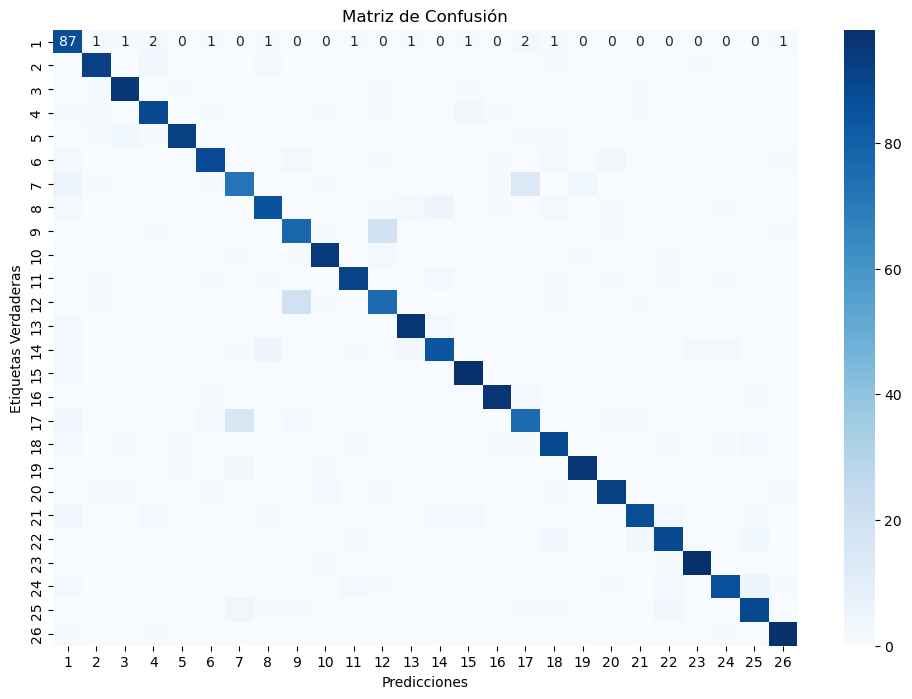

Accuracy por cada clase:
 [0.75652174 0.92       0.93137255 0.89       0.96842105 0.91666667
 0.75       0.88541667 0.74757282 0.92156863 0.93814433 0.73786408
 0.94117647 0.88421053 0.9245283  0.95049505 0.78350515 0.86407767
 0.95       0.92       0.92553191 0.89       0.97029703 0.93478261
 0.87254902 0.95098039]


In [16]:
# Se crea la matriz de confusión y se obtiene la accuracy por cada clase
class_accuracyE2 = createConfusionMatrix(final_test_labels, test_predictionsE2)

<h3> Gráfico de Accuracy por cada clase del Experimento 2</h3>
Se utiliza la función createClassAccuracyPlot() para crear y mostrar un gráfico que muestra la accuracy obtenida por cada clase.

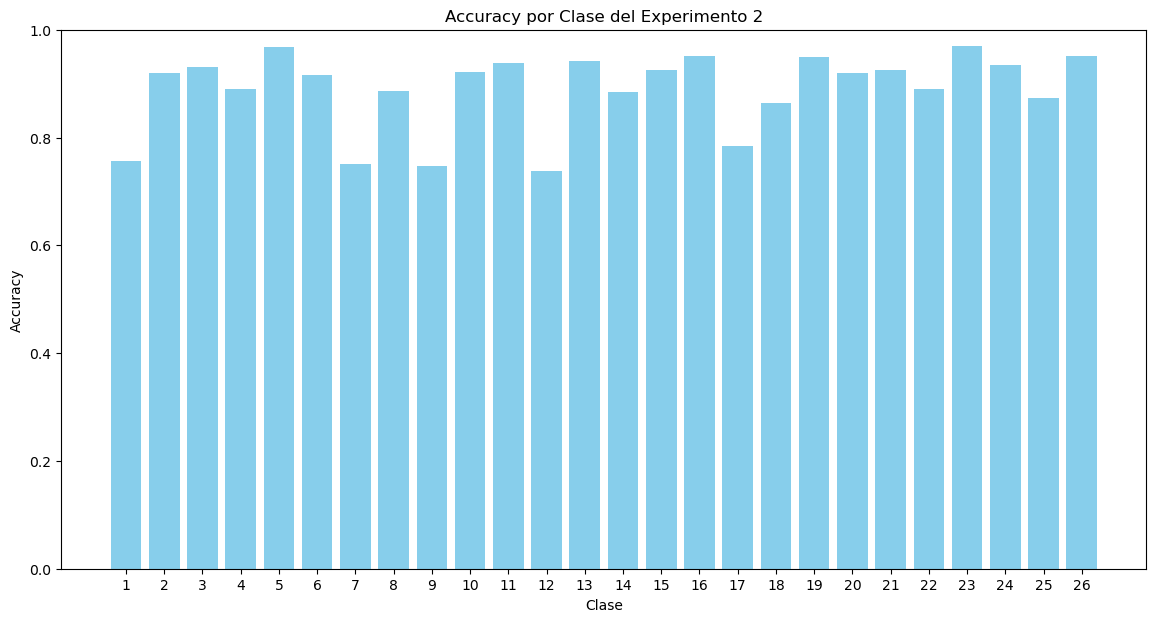

In [17]:
# Se muestra un gráfico de barras de la accuracy de cada clase
createClassAccuracyPlot(class_accuracyE2, 2)

<h3>Gráfico de Accuracy Total del modelo asociado al Experimento 2</h3>
Se utiliza la función createTotalAccuracyPlot() para crear y mostrar un gráfico que muestra la accuracy total.

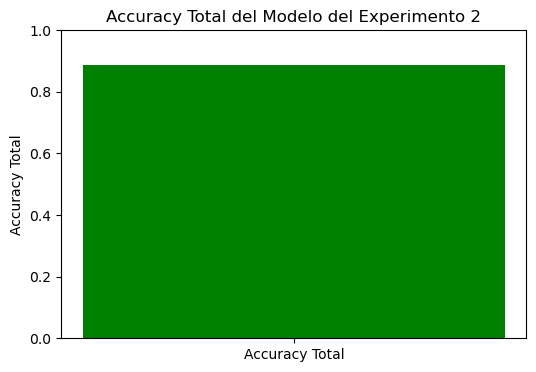

In [18]:
# Se muestra un gráfico de barras que representa el valor de la accuracy total
createTotalAccuracyPlot(accuracySVM2,2)

<h2>EXPERIMENTO 3: RED CONVOLUCIONAL SIMPLE</h2>
El tercer experimento consiste en evaluar una SVM donde los vectores son <b>extraídos de una red convolucional simple entrenada en EMNIST.</b> Para este experimento se utilizan los archivos <b>train_embeddings.csv</b> y <b>test_embeddings.csv</b>, por lo que es necesario realizar el proceso de obtener las muestras de entrenamiento y prueba, esta vez considerando los archivos .csv. Una vez se realiza el muestreo, se repite el uso de las funciones creadas en el experimento 1.

<h3>Lectura de archivos .csv</h3>
Pandas, gracias a la función read_csv, permite leer y guardar la información almacenada en los archivos .csv que se utilizan para este experimento.

In [19]:
# Se cargan los datos de entrenamiento y prueba de los archivos .csv usando Pandas
train_embeddings = pd.read_csv('train_embeddings.csv')
test_embeddings = pd.read_csv('test_embeddings.csv')


<h3>Obtención de muestras para el Experimento 3</h3>
Similar al procedimiento hecho antes del experimento 1, se obtienen las 1000 muestras de entrenamiento para cada clase y 100 muestras de prueba para cada clase

In [20]:
# Se configura una semilla para asegurar reproducibilidad
random_seed = 64

# Se crean listas donde se guardan los dataframes
final_train_list = []
final_test_list = []

# Se obtienen las etiquetas únicas de ambos conjuntos
unique_labels = pd.concat([train_embeddings['label'], test_embeddings['label']]).unique()

# Se itera sobre cada etiqueta única para seleccionar muestras
for label in unique_labels:
    # Se filtra por cada etiqueta
    train_samples = train_embeddings[train_embeddings['label'] == label]
    test_samples = test_embeddings[test_embeddings['label'] == label]
    
    # Se mezclan muestras utilizando la semilla
    train_samples = train_samples.sample(frac=1, random_state=random_seed).reset_index(drop=True)
    test_samples = test_samples.sample(frac=1, random_state=random_seed).reset_index(drop=True)
    
    # Se seleccionan las muestras necesarias y se añaden a la lista
    final_train_list.append(train_samples.head(num_train_per_class))
    final_test_list.append(test_samples.head(num_test_per_class))

# Se concatenan todas las muestras seleccionadas en un único dataFrame para entrenamiento y prueba
final_train = pd.concat(final_train_list).sample(frac=1, random_state=random_seed).reset_index(drop=True)
final_test = pd.concat(final_test_list).sample(frac=1, random_state=random_seed).reset_index(drop=True)

# Se obtienen los conjuntos de entrenamienta y prueba finales a utilizar
X_train_E3 = final_train.drop(columns=['label'])
y_train_E3 = final_train['label']
X_test_E3 = final_test.drop(columns=['label'])
y_test_E3 = final_test['label']

<h3>Entrenamiento, Predicción y Evaluación del modelo asociado al experimento 3</h3>
Similar al experimento 1 y 2 se utiliza la función modelProcess(). Esta vez, no se requiere definir algo adicional en el Pipeline.

In [21]:
# Creación del pipeline del experimento 3
svm_final_pipeline = Pipeline([
    ('svm', SVC(kernel='rbf'))
])

# Se obtiene la accuracy total y las predicciones del modelo. Se imprime el reporte de clasificación
accuracySVM3, test_predictionsE3 = modelProcess(svm_final_pipeline, X_train_E3, X_test_E3, y_train_E3, y_test_E3)


Accuracy total de la SVM:  0.9415384615384615
Reporte de Clasificación (Métricas) de todas las clases:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       100
           1       0.96      1.00      0.98       100
           2       0.96      0.96      0.96       100
           3       0.97      1.00      0.99       100
           4       0.96      0.98      0.97       100
           5       0.97      0.98      0.98       100
           6       0.91      0.84      0.87       100
           7       0.97      0.97      0.97       100
           8       0.69      0.70      0.69       100
           9       0.94      0.93      0.93       100
          10       0.97      0.96      0.96       100
          11       0.73      0.71      0.72       100
          12       0.98      0.97      0.97       100
          13       0.99      0.95      0.97       100
          14       0.99      0.96      0.97       100
          15       1.00      0.9

<h3>Matriz de Confusión y Accuracy por cada clase del Experimento 3</h3>
Se obtiene la Matriz de Confusión y la Accuracy asociada a cada clase. Para ello, se utiliza la función createConfusionMatrix()

Matriz de confusión:
 [[ 96   0   1   1   0   0   0   0   0   0   0   0   0   0   0   0   2   0
    0   0   0   0   0   0   0   0]
 [  0 100   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0  96   0   1   0   0   0   0   0   0   1   0   0   0   0   0   0
    0   0   1   0   0   0   0   1]
 [  0   0   0 100   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  1   0   0   0  98   1   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  1   0   0   0   0  98   0   0   0   0   0   0   0   0   0   0   0   0
    0   1   0   0   0   0   0   0]
 [  1   1   1   0   0   0  84   0   0   1   0   0   0   0   0   0  10   0
    1   0   0   0   0   0   1   0]
 [  0   1   0   0   0   0   0  97   0   0   0   1   0   0   0   0   0   0
    0   0   0   0   0   1   0   0]
 [  0   1   0   0   1   0   0   0  70   3   0  24   0   0   0   0   0   1
    0   0   0   0   0   0   0   

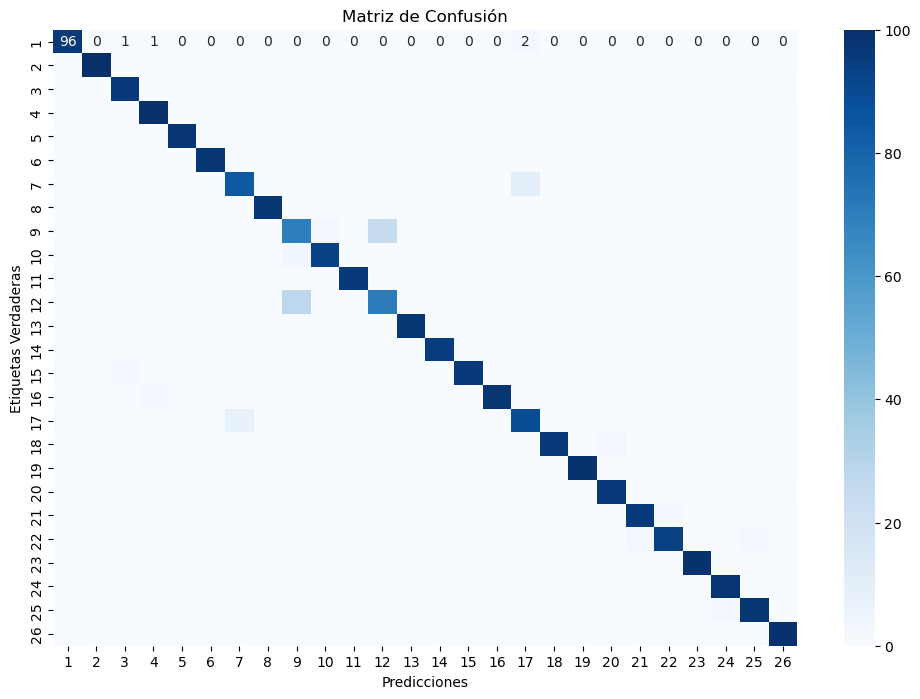

Accuracy por cada clase:
 [0.93203883 0.96153846 0.96       0.97087379 0.96078431 0.97029703
 0.91304348 0.97       0.68627451 0.93939394 0.96969697 0.73195876
 0.97979798 0.98958333 0.98969072 1.         0.86407767 0.98969072
 0.98019802 0.95049505 0.95049505 0.97916667 0.99       0.95145631
 0.92380952 0.98019802]


In [22]:
# Se crea la matriz de confusión y se obtiene la Accuracy por cada clase
class_accuracyE3 = createConfusionMatrix(y_test_E3, test_predictionsE3)

<h3> Gráfico de Accuracy por cada clase del Experimento 3 </h3>
Se utiliza la función createClassAccuracyPlot() para crear y mostrar un gráfico que muestra la accuracy obtenida por cada clase.

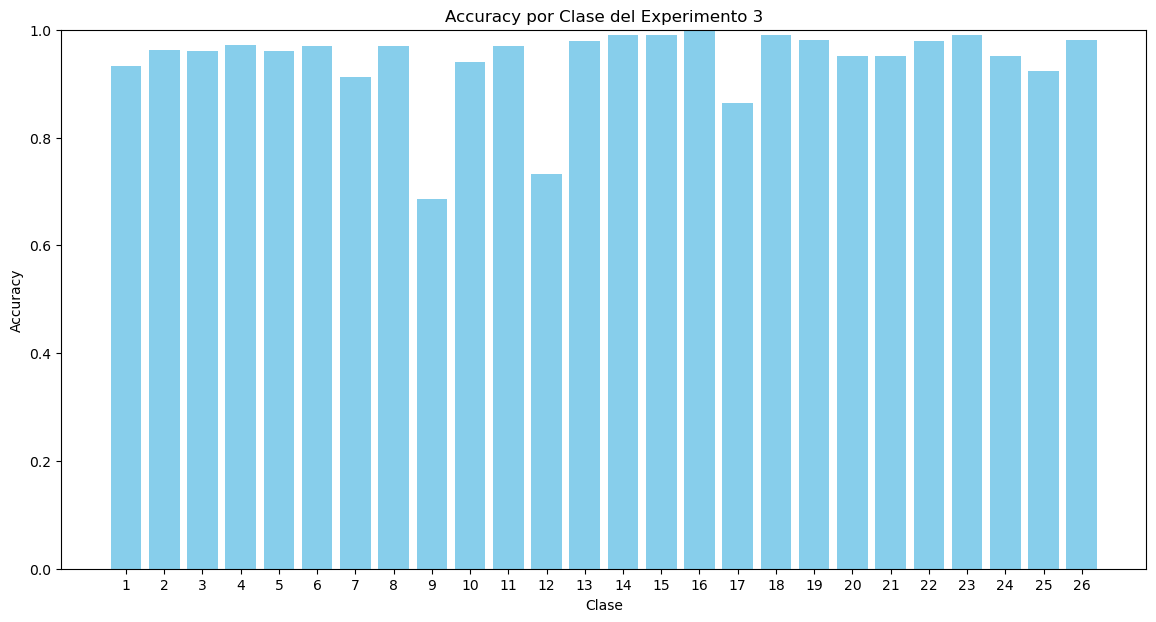

In [23]:
# Se crea el gráfico de barras que muestras la accuracy por clase
createClassAccuracyPlot(class_accuracyE3, 3)

<h3> Gráfico de Accuracy Total del modelo asociado al Experimento 3 </h3>
Se utiliza la función createTotalAccuracyPlot() para crear y mostrar un gráfico que muestra la accuracy total.

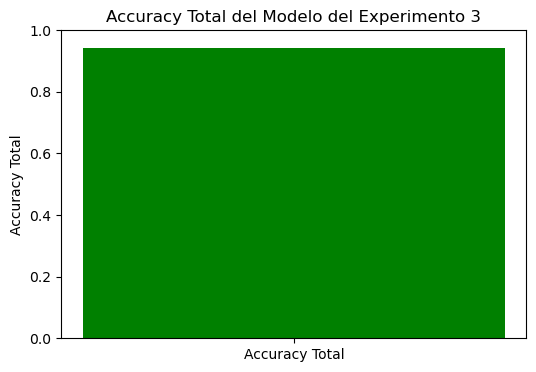

In [24]:
# Se crea un gráfico que muestra el valor de la Accuracy total
createTotalAccuracyPlot(accuracySVM3,3)

<h2>COMPARACIÓN ENTRE LOS EXPERIMENTOS</h2>

Con los experimentos ya realizados, ahora se pueden obtener tablas y gráficos que nos permitan comparar los valores de Accuracy obtenidos

<h3>Tabla de Accuracy por cada clase</h3>
Utilizando Pandas, se crea un dataframe para registrar los valores de accuracy de cada clase obtenidas en cada experimento. AccuracyEX representa las accuracy por clase obtenidas en el experimento X, con X siendo 1, 2 o 3 dependiendo del experimento.

In [25]:
# Se crea un dataframe, registrando los valores de accuracy por cada clase
data = {'AccuracyE1': class_accuracyE1,
        'AccuracyE2': class_accuracyE2,
        'AccuracyE3': class_accuracyE3
    }
df_accuracy = pd.DataFrame(data)
display(df_accuracy)

,AccuracyE1,AccuracyE2,AccuracyE3
0,0.765217,0.756522,0.932039
1,0.893204,0.920000,0.961538
2,0.913462,0.931373,0.960000
3,0.872549,0.890000,0.970874
4,0.958333,0.968421,0.960784
5,0.907216,0.916667,0.970297
6,0.739130,0.750000,0.913043
7,0.894737,0.885417,0.970000
8,0.710280,0.747573,0.686275
9,0.930000,0.921569,0.939394


<h3>Comparación de Accuracy Total</h3>
Se crea un gráfico de barras para poder comparar los valores de accuracy total.

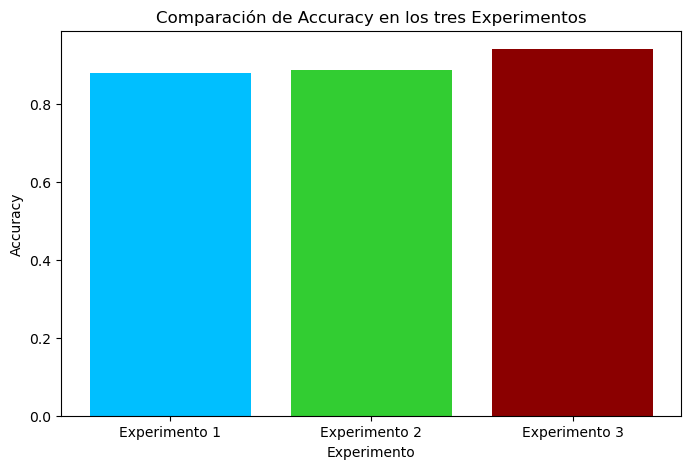

In [26]:
# Nombres de los experimentos
experiment_names = ['Experimento 1', 'Experimento 2', 'Experimento 3']
# Valores de precisión
accuracies = [accuracySVM1, accuracySVM2, accuracySVM3]
# Se crea un gráfico de barras
plt.figure(figsize=(8, 5))  # Se configura el tamaño de figura
plt.bar(experiment_names, accuracies, color=['deepskyblue', 'limegreen', 'darkred'])
plt.title('Comparación de Accuracy en los tres Experimentos')
plt.xlabel('Experimento')
plt.ylabel('Accuracy')
plt.show()

<h3>Comparación de Accuracy por Clase</h3>
Se crea un gráfico de barras para comparar los valores de accuracy por cada clase obtenidos en cada experimento.


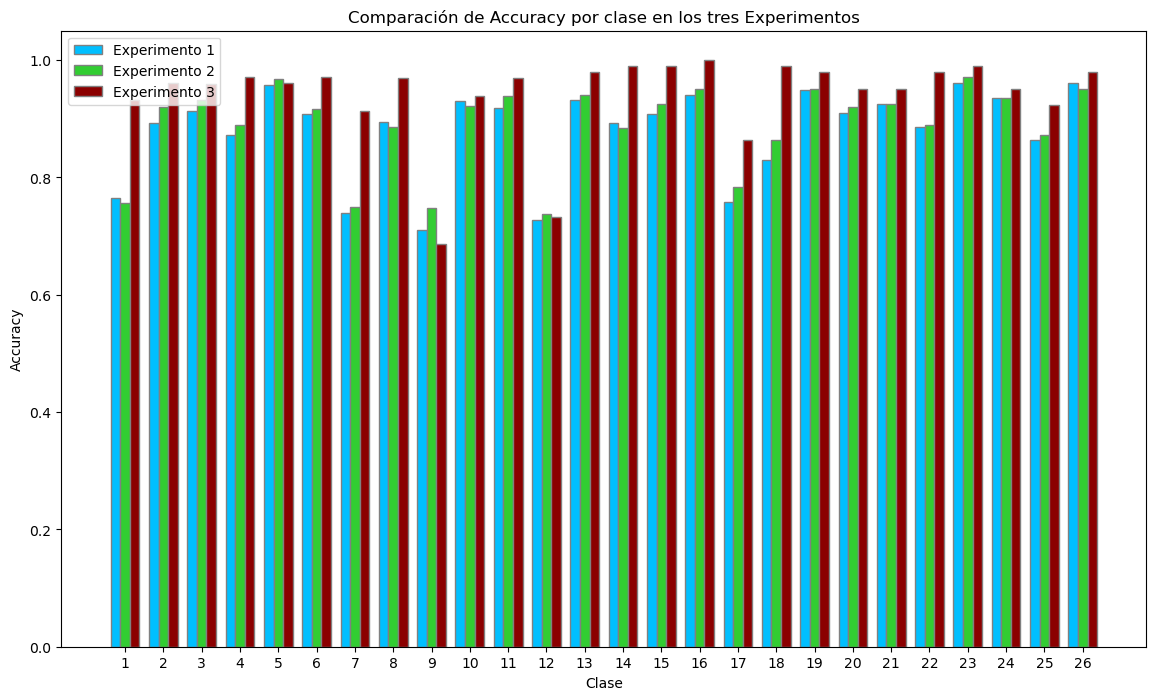

In [27]:
# Se define la anchura de las barras
bar_width = 0.25

# Se define las posiciones de las barras para cada grupo
r1 = np.arange(len(class_accuracyE1))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Se crea el gráfico de barras agrupadas
plt.figure(figsize=(14, 8))
plt.bar(r1, class_accuracyE1, color='deepskyblue', width=bar_width, edgecolor='grey', label='Experimento 1')
plt.bar(r2, class_accuracyE2, color='limegreen', width=bar_width, edgecolor='grey', label='Experimento 2')
plt.bar(r3, class_accuracyE3, color='darkred', width=bar_width, edgecolor='grey', label='Experimento 3')

# Se agregan leyendas, títulos y etiquetas
plt.xlabel('Clase')
plt.ylabel('Accuracy')
plt.xticks([r + bar_width for r in range(len(class_accuracyE1))], range(1,27))
plt.title('Comparación de Accuracy por clase en los tres Experimentos')
plt.legend()
plt.show()


<h2>MODIFICACIÓN DE HYPERPARAMETROS</h2>
Se busca comprobar como cambian los valores al utilizar valores distintos a los por defecto de la SVM. A continuación, se realizarán pruebas para cada experimento. NOTA: Solo se realizan pruebas con C dado que se intentó hacer pruebas modificando Gamma, pero el tiempo de ejecución aumentó demasiado y nunca terminó.

In [28]:
# Configuración del pipeline
svm_pipelineC = Pipeline([
    ('svm', SVC(kernel='rbf', C = 10))     # SVM con kernel RBF
])

# Se llama a la función modelProcess() y se obtienen las predicciones del modelo junto con la accuracy total del modelo. Además, se imprime
# el reporte de clasificación.
accuracySVM1C, test_predictionsE1C = modelProcess(svm_pipelineC, final_train_images, final_test_images, final_train_labels, final_test_labels)

Accuracy total de la SVM:  0.8965384615384615
Reporte de Clasificación (Métricas) de todas las clases:
              precision    recall  f1-score   support

           1       0.80      0.90      0.85       100
           2       0.89      0.93      0.91       100
           3       0.93      0.95      0.94       100
           4       0.92      0.91      0.91       100
           5       0.94      0.93      0.93       100
           6       0.93      0.91      0.92       100
           7       0.74      0.73      0.74       100
           8       0.96      0.88      0.92       100
           9       0.74      0.78      0.76       100
          10       0.93      0.93      0.93       100
          11       0.94      0.93      0.93       100
          12       0.77      0.73      0.75       100
          13       0.98      0.96      0.97       100
          14       0.91      0.89      0.90       100
          15       0.93      0.97      0.95       100
          16       0.94      0.9

In [29]:
# Configución del pipeline con PCA
svm_pca_pipelineC = Pipeline([
    ('pca', PCA(n_components = 128)),  # Se utiliza PCA para reducir dimensiones a 128
    ('svm', SVC(kernel = 'rbf', C = 10))       # SVM con kernel RBF
])

# Se obtiene la accuracy del modelo y los resultados de predicción
accuracySVM2C, test_predictionsE2C = modelProcess(svm_pca_pipelineC, final_train_images, final_test_images, final_train_labels, final_test_labels)

Accuracy total de la SVM:  0.9023076923076923
Reporte de Clasificación (Métricas) de todas las clases:
              precision    recall  f1-score   support

           1       0.80      0.90      0.85       100
           2       0.90      0.93      0.92       100
           3       0.91      0.95      0.93       100
           4       0.91      0.91      0.91       100
           5       0.96      0.91      0.93       100
           6       0.95      0.91      0.93       100
           7       0.74      0.75      0.75       100
           8       0.90      0.86      0.88       100
           9       0.79      0.77      0.78       100
          10       0.95      0.94      0.94       100
          11       0.94      0.93      0.93       100
          12       0.78      0.78      0.78       100
          13       0.97      0.96      0.96       100
          14       0.91      0.88      0.89       100
          15       0.95      0.97      0.96       100
          16       0.94      0.9

In [30]:
# Creación del pipeline del experimento 3
svm_final_pipelineC = Pipeline([
    ('svm', SVC(kernel='rbf', C = 10))
])

# Se obtiene la accuracy total y las predicciones del modelo. Se imprime el reporte de clasificación
accuracySVM3C, test_predictionsE3C = modelProcess(svm_final_pipelineC, X_train_E3, X_test_E3, y_train_E3, y_test_E3)

Accuracy total de la SVM:  0.9373076923076923
Reporte de Clasificación (Métricas) de todas las clases:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       100
           1       0.93      1.00      0.96       100
           2       0.98      0.96      0.97       100
           3       0.98      0.98      0.98       100
           4       0.97      0.97      0.97       100
           5       0.96      0.99      0.98       100
           6       0.89      0.84      0.87       100
           7       0.97      0.96      0.96       100
           8       0.69      0.72      0.70       100
           9       0.93      0.94      0.94       100
          10       0.96      0.96      0.96       100
          11       0.73      0.70      0.71       100
          12       0.99      0.97      0.98       100
          13       0.98      0.96      0.97       100
          14       0.98      0.96      0.97       100
          15       0.97      0.9

Los analisis relacionados a los resultados se realizan en el informe escrito que acompaña a este código. En él, se revisa el desempeño de los modelos y cuales son las ventajas, desventajas y diferencias que existen entre los modelos.